In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import transformers
import shap_customized.shap as shap
import pickle
np.random.seed(seed=0)

/home/ljrjerry/anaconda3/envs/env38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
with open("/nfs/turbo/coe-vvh/ljr/Censorship/shap_data/beeswarm/v0328_shap_vals_test_uniq_en_TR_samp500.pkl", 'rb') as f:
    shap_values = pickle.load(f)

# generate shap_values

In [24]:
data = pd.read_csv('/nfs/turbo/coe-vvh/ljr/Censorship/data/v_0305/dataset_test_uniq_en.csv', engine='python', index_col=0)
data['full_text_wo_label'] = data['full_text_wo_label'].str.replace(r'[^\w\s#]', '', regex=True).str.strip()
data = data.loc[data['full_text_wo_label'].str.contains(' ')]


In [38]:
from tqdm import tqdm
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=500) for v in x])#.cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    # val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    # modify val
    val = scores[:, 1]
    return val

tokenizer = transformers.AutoTokenizer.from_pretrained("roberta-base")
model = transformers.AutoModelForSequenceClassification.from_pretrained("roberta-base")#.cuda()

model.load_state_dict(torch.load(
    '/nfs/turbo/coe-vvh/ljr/Censorship/models/20230311-10:45:13_binary_0.1_8_1e-05_adamw.pt', map_location=torch.device('cpu')))

explainer = shap.Explainer(f, shap.maskers.Text())

# data = data[data['full_text_wo_label'].str.contains(' ')]


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RuntimeError: Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
cannot import name 'layers' from partially initialized module 'keras' (most likely due to a circular import) (/home/ljrjerry/anaconda3/envs/env38/lib/python3.8/site-packages/keras/__init__.py)

In [ ]:
explainer = shap.Explainer(f, shap.maskers.Text())

In [ ]:
withheld_list = [None] # 'TR', 'RU', 
# withheld_list = ['TR', 'RU', 'DE', 'FR', 'IN']
# withheld_list = ['DE']
# withheld_list = [None]
# sample 500

In [ ]:

for withheld in tqdm(withheld_list):
    flag = 1        
    new_data = 0
    if withheld is not None:
        new_data = data[data['withheld'].fillna('').str.contains(f"'{withheld}")]
    else:
        new_data = data
    new_data.to_csv(f'/nfs/turbo/coe-vvh/ljr/Censorship/shap_data/beeswarm/v_0328_dataset_test_uniq_en_{str(withheld)}.csv')
    if withheld is not None:
        if withheld == 'RU':
            new_data = new_data.sample(n=400, replace=False, random_state=1)
        elif withheld == 'DE':
            new_data = new_data.sample(n=500, replace=False, random_state=1)
        elif withheld == 'IN':
            new_data = new_data
        else:
            new_data = new_data.sample(n=500, replace=False, random_state=1) # for test
    else:
        new_data = new_data.sample(n=5000, replace=False, random_state=1)

    shap_values_bert = explainer(new_data['full_text_wo_label'].values.tolist())

    with open(f'/nfs/turbo/coe-vvh/ljr/Censorship/shap_data/beeswarm/v0328_shap_vals_test_uniq_en_{str(withheld)}_samp500.pkl', 'wb') as f:
        pickle.dump(shap_values_bert, f)
    shap.plots.bar(shap_values_bert.mean(0), max_display=50)
    
            
#     shap.plots.beeswarm(shap_values)


['"Dear', 'jihad', 'anti-White', '"Berkeley', 'Sharia,', 'ISIS', '"BENGHAZI', 'ISIS....', '"These', 'Islam.', '"We', '"A', '"Martin', 'German', '"YPG', 'Whites', 'Germany', '"Two', 'race', '"But', 'Sharia-adherent', 'anti-Whiteness.', '#EndFGM', '"Breaking:', 'Hitler', '#fattuesday"', 'CAIR,', '#Würselen!', 'Turkish', '#ReligiousFreedom', 'White', '"It', 'warned!', '"Refugee"', 'Alexandr', 'Jihad', 'Islam:', '#Europe', 'Islamic', 'Najka,Iskan,Hajj', 'there...because', '#nationalism', 'Islam', '"refugees"...', 'UK.', 'Islam?”', 'Reagan', 'Waffen', 'people', 'confused"', '#HolocaustMemorialDay', 'Ramadan', 'Germany:', 'Muslim', 'ISLAM', 'society"', 'Refuse', '#Tucker', 'peoples', '"It\'s', 'Has', 'more:', "'How", 'loser', '"So,', 'people,', '"This', '"Some', 'order."', '"The', 'RISE', 'monitor', 'Leftists...', 'about:', 'social', 'up."', 'virtue-signalling."', 'EUROPA', '"blasphemous"', 'YouTube', 'girls', 'nder', 'kitten', '!', 'girls.', 'Involved!"', '""', 'Ronald', 'takes', 'free', 'C

Glyph 128073 missing from current font.
Glyph 127995 missing from current font.
Glyph 128073 missing from current font.
Glyph 127995 missing from current font.


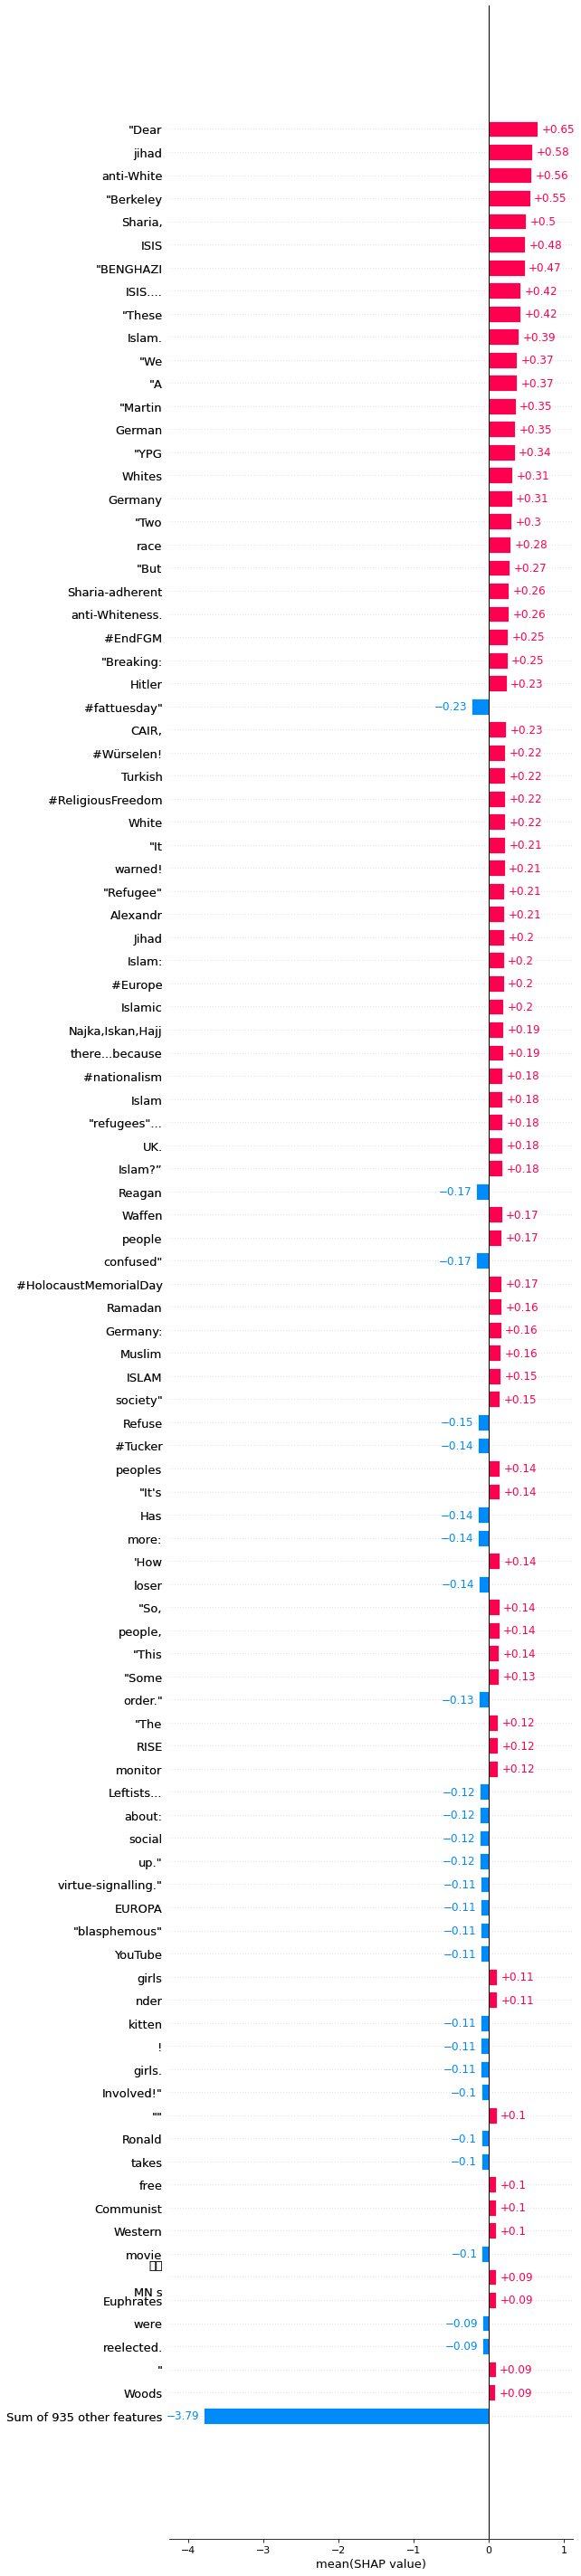

In [ ]:
shap.plots.bar(shap_values_bert.mean(0), max_display=100)

# beeswarm xgboost test

In [26]:
import xgboost
import shap

# train XGBoost model
X1,y1 = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X1, y1)

# compute SHAP values
explainer1 = shap.Explainer(model, X1)
shap_values1 = explainer1(X1)

2023-03-28 00:49:53.762122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 00:49:54.256812: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-28 00:50:00.804958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ljrjerry/anaconda3/envs/env38/lib/python3.8/site-packages/cv2/../../lib64:/opt/slurm/lib64:
2023-03-28 00:50:00.805417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load

In [27]:
X1,y1

(        Age  Workclass  Education-Num  Marital Status  Occupation  \
 0      39.0          7           13.0               4           1   
 1      50.0          6           13.0               2           4   
 2      38.0          4            9.0               0           6   
 3      53.0          4            7.0               2           6   
 4      28.0          4           13.0               2          10   
 ...     ...        ...            ...             ...         ...   
 32556  27.0          4           12.0               2          13   
 32557  40.0          4            9.0               2           7   
 32558  58.0          4            9.0               6           1   
 32559  22.0          4            9.0               4           1   
 32560  52.0          5            9.0               2           4   
 
        Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
 0                 0     4    1        2174.0           0.0            40.0   


In [28]:
shap_values1[0]

.values =
array([ 0.62066666, -0.4340129 ,  0.40111691, -0.41627076, -0.11005208,
       -0.46145511,  0.03216866,  0.33387261, -2.97870277, -0.11033077,
       -0.09677085,  0.01754525])

.base_values =
-2.6846917531982397

.data =
array([3.900e+01, 7.000e+00, 1.300e+01, 4.000e+00, 1.000e+00, 0.000e+00,
       4.000e+00, 1.000e+00, 2.174e+03, 0.000e+00, 4.000e+01, 3.900e+01])

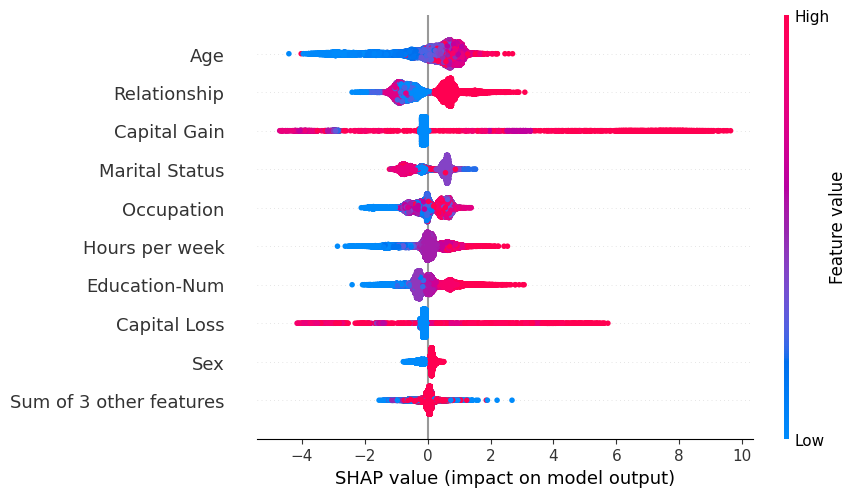

In [31]:
shap.plots.beeswarm(shap_values1)


In [21]:
y1

array([False, False, False, ..., False, False,  True])

In [30]:
shap_values1.data

array([[39.,  7., 13., ...,  0., 40., 39.],
       [50.,  6., 13., ...,  0., 13., 39.],
       [38.,  4.,  9., ...,  0., 40., 39.],
       ...,
       [58.,  4.,  9., ...,  0., 40., 39.],
       [22.,  4.,  9., ...,  0., 20., 39.],
       [52.,  5.,  9., ...,  0., 40., 39.]])

In [31]:
shap_values1.feature_names

['Age',
 'Workclass',
 'Education-Num',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Country']

In [28]:
X1

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


# bar plot

https://drive.google.com/drive/folders/1NLhaS9aDJIrTTNi2AViqUqvCgyEkIMYZ?usp=share_link

In [ ]:
type(values)

numpy.ndarray

In [ ]:
len(values[0]), len(features)


(5360, 5360)

In [ ]:
order

array([2908, 4607, 2084, ..., 3611, 3924,  602])

In [ ]:
features[2908], values[0][2908]

('#MSG9बर9Day5', 0.9520368287776364)

['ÊzîdîPress Wh', '#ErdogansWarOnAfrin', '#EnesKanterLightFoundation', 'YPJKurds', 'Gulenists', '#BreakSilenceOnAfrin', '#DictatorErdogan', 'YUNANİSTANDA', 'Dêrik', '#KnicksWay', 'proErdogan', 'Hizmet', 'Gülmen', '#StopKosovoExtradition', 'Gülen', '#PrisonStrike2018', 'TurkishRussian', 'Gambling', 'YPGYPJSDF', 'manbij', '#Refugees', '#WomenRiseUpForAfrin', 'WRaqqa', 'Erdoganists', '#Hizmet', 'TURKEY', 'Erdoğan', 'Manbij', '#Manbij', '#IFLC2018NewYork', 'Mehmet', '#Riseup4Rojava', 'Gülenshit', '#Knicks', 'Gulenlinked', 'Erdogan', '#Muslim', 'Erdoğans', '#MassacrePlansInTurkey', '#Barcelona', 'Gulens', 'UnconfirmedTurkish', 'Bircê', 'KURDS', 'Öğretmen e', 'Rojava', '#TURKEY', '#BoycottTurkeyTourism', '#Turkish', 'Sum of 4533 other features']


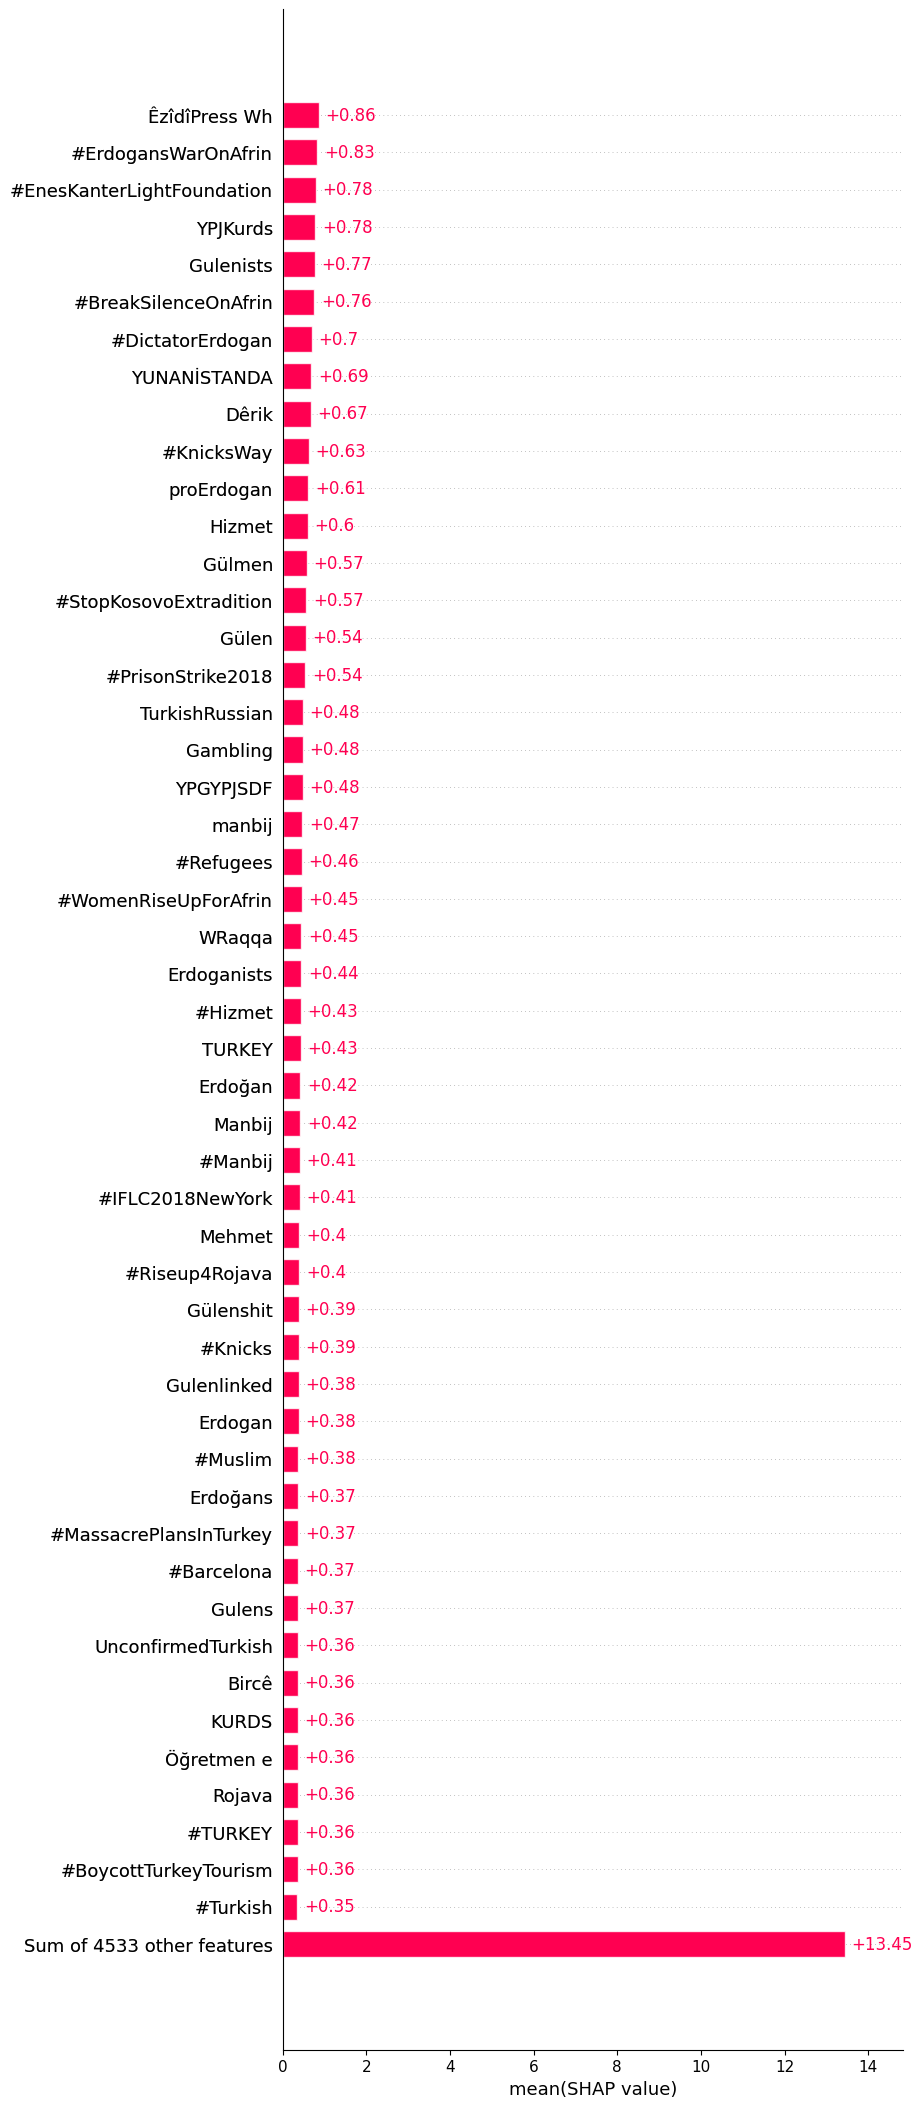

In [19]:
values, features, order = shap.plots.bar(shap_values.mean(0), max_display=50)
# shap.plots.beeswarm(shap_values)
values_sort, features_sort = [], []
for idx, val in enumerate(order):
    values_sort.append(values[0][val])
    features_sort.append(features[val])
# csv_df = pd.DataFrame()
# csv_df['Word'] = features_sort
# csv_df['Value'] = values_sort
# csv_df.to_csv("/nfs/turbo/coe-vvh/ljr/Censorship/shap_data/spreadsheet/IN_samp500_sorted.csv")

# beeswarm

In [26]:
data.loc[data['full_text_wo_label'].str.contains('ÊzîdîPress Wh')]


,possibly_sensitive,reply_settings,id,public_metrics,entities,lang,author_id,text,created_at,edit_history_tweet_ids,...,referenced_author_id,referenced_text,referenced_created_at,referenced_edit_history_tweet_ids,referenced_withheld,referenced_referenced_tweets,referenced_geo,full_text,full_text_wo_label,censored
27176,False,everyone,801925610759143427,"{'retweet_count': 35, 'reply_count': 5, 'like_...","{'annotations': [{'start': 53, 'end': 62, 'pro...",en,3.244921e+09,Friends I say goodnight with this beautiful vi...,2016-11-24T23:08:59.000Z,['801925610759143427'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Friends I say goodnight with this beautiful vi...,Friends I say goodnight with this beautiful vi...,1


In [32]:
for cnt, tmp in enumerate(new_shap_values.values):
    if (tmp[0] != 0):
        print(cnt)

1


In [28]:
new_shap_values[0].data

.values =
array([0., 0., 0., ..., 0., 0., 0.])

.data =
array(['ÊzîdîPress Wh', '#ErdogansWarOnAfrin',
       '#EnesKanterLightFoundation', ..., 'monitor', 'years', 'özellikle'],
      dtype='<U30')

In [20]:
import shapley_value as sv
X, feature_names = sv.convert_shap_values(shap_values, sorted_feature_names_list=features_sort)
new_shap_values = sv.build_new_shap_values(X, feature_names, shap._explanation.Explanation)


feature order:  [   0    1    2 ... 4579 4580 4581]


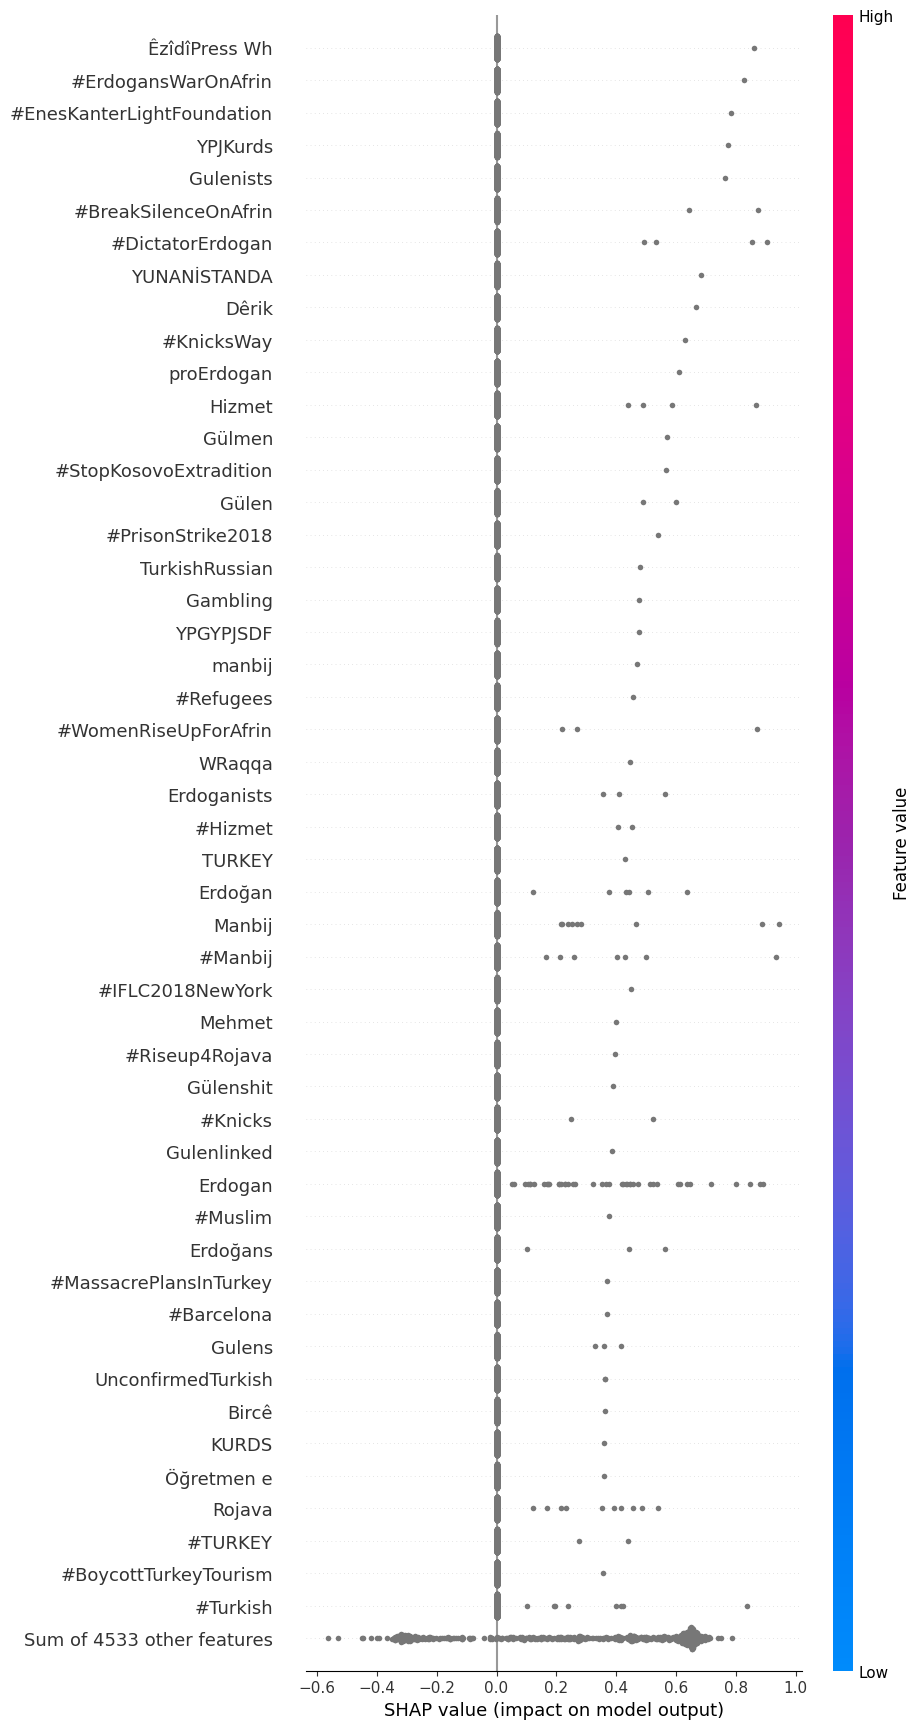

In [21]:
shap.plots.beeswarm(shap_values=new_shap_values, max_display=50, order=np.arange(new_shap_values[0].values.shape[0]), follow_bar_plot_order=True)


# Something else

In [31]:
data['full_text_wo_label'] = data['full_text_wo_label'].apply(lambda x: x.strip() if type(x) != float else "")
data['full_text_wo_label']
data.to_csv('/nfs/turbo/coe-vvh/ljr/Censorship/data/v_0305/dataset_test_uniq.csv')

468359    Jesus said, “Come to me, all who labor and are...
190098    : "Fethullah Gülen Hocaefendi'nin Çağlayan der...
280600    Gracias a Dios llegan las primeras vacunas al ...
148658                         İsrail Gazze’yi Bombalıyor -
30911     : "Фейсбук: число напавших повстанцев на росси...
                                ...                        
73340     Hakimlerden önce küçük tetikçi Cem, Cumhuriyet...
87647     Allah bunların akıllarını almış. Ensar vakfı z...
425336    Avui al parlament de Ñ cabreix monumental per ...
269772    Charred bodies and besieged families.. Scenes ...
11892     Ahlaksizlik pirim yapinca,namus bu kadar hakar...
Name: full_text_wo_label, Length: 45236, dtype: object

In [38]:
# use_cuda = False
# if use_cuda:
# load a BERT sentiment analysis model
tokenizer = transformers.AutoTokenizer.from_pretrained("roberta-base")
model = transformers.AutoModelForSequenceClassification.from_pretrained("roberta-base").cuda()

model.load_state_dict(torch.load(
    '/nfs/turbo/coe-vvh/ljr/Censorship/models/20230219-03:24:33_binary_0.1_8_1e-05_adamw.pt'))

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=500) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
# explainer = shap.Explainer(f, tokenizer)

In [33]:
# else:
# load a BERT sentiment analysis model
tokenizer = transformers.AutoTokenizer.from_pretrained("roberta-base")
model = transformers.AutoModelForSequenceClassification.from_pretrained("roberta-base")

model.load_state_dict(torch.load(
    '/nfs/turbo/coe-vvh/ljr/Censorship/models/20230311-10:45:13_binary_0.1_8_1e-05_adamw.pt', map_location=torch.device("cpu")))


# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=500) for v in x])
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    # val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    # modify val
    val = scores[:, 1]
    return val

# build an explainer using a token masker
# explainer = shap.Explainer(f, tokenizer)
# explainer = shap.Explainer(f, shap.maskers.Text(r"\s"))

# explain the model's predictions on IMDB reviews
# shap_values = explainer(tmp_df['full_text_proc'].values.tolist())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

# Explainer

In [36]:
explainer = shap.Explainer(f, shap.maskers.Text())
shap_values = explainer(["Friends I say goodnight with this beautiful video by ÊzîdîPress Who are the Ezidi pls watch"])
shap.plots.text(shap_values)

RuntimeError: Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
cannot import name 'layers' from partially initialized module 'keras' (most likely due to a circular import) (/home/ljrjerry/anaconda3/envs/env38/lib/python3.8/site-packages/keras/__init__.py)

In [33]:
explainer = shap.Explainer(f, shap.maskers.Text())
shap_values = explainer(
    ["Friends I say goodnight with this beautiful video by ÊzîdîPress Who are the Ezidi pls watch"])
shap.plots.text(shap_values)


2023-03-29 02:48:13.413242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 02:48:18.235703: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-29 02:48:33.235363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ljrjerry/anaconda3/envs/env38/lib/python3.8/site-packages/cv2/../../lib64:/opt/slurm/lib64:
2023-03-29 02:48:33.236150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load

KeyboardInterrupt: 

In [8]:
shap_values = explainer(["""[ESPN] Florida-Louisville: 5 things to watch: 
GAINESVILLE, Fla. -- Here are five things to watch fo...  #Louisville"""])
shap.plots.text(shap_values)


In [19]:
shap_values = explainer([": [Did you know?] Hidayet Karaca, Journo &amp; Executive of a Turkish TV network, been in prison since Dec of 2014 in #Tur "])
shap.plots.text(shap_values)



[':', '[Did', 'you', 'know?]', 'Hidayet', 'Karaca,', 'Journo', '&amp;', 'Executive', 'of', 'a', 'Turkish', 'TV', 'network,', 'been', 'in', 'prison', 'since', 'Dec', 'of', '2014', 'in', '#Tur', '']
[': ', '[Did ', 'you ', 'know?] ', 'Hidayet ', 'Karaca, ', 'Journo ', '&amp; ', 'Executive ', 'of ', 'a ', 'Turkish ', 'TV ', 'network, ', 'been ', 'in ', 'prison ', 'since ', 'Dec ', 'of ', '2014 ', 'in ', '#Tur ', '']
[': ', '[Did ', 'you ', 'know?] ', 'Hidayet ', 'Karaca, ', 'Journo ', '&amp; ', 'Executive ', 'of ', 'a ', 'Turkish ', 'TV ', 'network, ', 'been ', 'in ', 'prison ', 'since ', 'Dec ', 'of ', '2014 ', 'in ', '#Tur ', '']


The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
Partition explainer: 2it [00:54, 54.29s/it]               

[':', '[Did', 'you', 'know?]', 'Hidayet', 'Karaca,', 'Journo', '&amp;', 'Executive', 'of', 'a', 'Turkish', 'TV', 'network,', 'been', 'in', 'prison', 'since', 'Dec', 'of', '2014', 'in', '#Tur', '']
[': ', '[Did ', 'you ', 'know?] ', 'Hidayet ', 'Karaca, ', 'Journo ', '&amp; ', 'Executive ', 'of ', 'a ', 'Turkish ', 'TV ', 'network, ', 'been ', 'in ', 'prison ', 'since ', 'Dec ', 'of ', '2014 ', 'in ', '#Tur ', '']
[': ', '[Did ', 'you ', 'know?] ', 'Hidayet ', 'Karaca, ', 'Journo ', '&amp; ', 'Executive ', 'of ', 'a ', 'Turkish ', 'TV ', 'network, ', 'been ', 'in ', 'prison ', 'since ', 'Dec ', 'of ', '2014 ', 'in ', '#Tur ', '']


In [18]:
start = 0
offset_ranges = []
input_ids = []
for word_i, word in enumerate([':', '[Did', 'you', 'know?]', 'Hidayet', 'Karaca,', 'Journo ', '&amp;', 'Executive', 'of', 'a', 'Turkish', 'TV', 'network,', 'been ', 'in', 'prison ', 'since', 'Dec', 'of', '2014 ', 'in', '#Tur', '']):
    end = start + len(word)
    offset_ranges.append((start, end))
    input_ids.append(": [Did you know?] Hidayet Karaca, Journo &amp; Executive of a Turkish TV network, been in prison since Dec of 2014 in #Tur "[start:end])
    start = end
input_ids

[':',
 ' [Di',
 'd y',
 'ou kno',
 'w?] Hid',
 'ayet Ka',
 'raca, J',
 'ourno',
 ' &amp; Ex',
 'ec',
 'u',
 'tive of',
 ' a',
 ' Turkish',
 ' TV n',
 'et',
 'work, b',
 'een i',
 'n p',
 'ri',
 'son s',
 'in',
 'ce D',
 '']

# Explainer testing

In [ ]:
explainer = shap.Explainer(f, shap.maskers.Text())
shap_values = explainer(["#OccupyOakland: footage shows police", "Just voted Ken."])
shap.plots.text(shap_values)

In [ ]:
shap_values = explainer(["..."])
shap.plots.text(shap_values)

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
x = ['...']
tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=500) for v in x])
outputs = model(tv)[0].detach().cpu().numpy()
scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
# val = sp.special.logit(scores[:,1]) # use one vs rest logit units
# modify val
val = scores[:, 1]

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


In [ ]:
outputs, scores, val

(array([[ 0.29908544, -0.33372974]], dtype=float32),
 array([[0.6531275 , 0.34687245]], dtype=float32),
 array([0.34687245], dtype=float32))

In [ ]:
shap_values = explainer(data['text_proc'].values[:5].tolist())
shap.plots.text(shap_values)

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
Partition explainer: 6it [04:17, 51.58s/it]                       


: 

In [34]:
class SimpleTokenizer():  # pylint: disable=too-few-public-methods
    """ A basic model agnostic tokenizer.
    """

    def __init__(self, split_pattern=r"\W+"):
        """ Create a tokenizer based on a simple splitting pattern.
        """
        # self.split_pattern = re.compile(split_pattern)

        # Load the pre-trained BERT tokenizer for multilingual language processing
        import transformers
        self.model_name = "roberta-base"
        # self.model_name = 'bert-base-multilingual-cased'
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.model_name)

    def word_tokenize(self, text):
        text = re.sub("\n", ' ', text.strip())
        # text = re.sub(r'[^\w\s]', '', text)
        tokenizer = self.tokenizer
        token_ids = tokenizer.encode(text)
        tokens = tokenizer.convert_ids_to_tokens(token_ids)
        # print(tokens)

        # example tokens: ['[CLS]', 'This', 'is', 'an', 'example', 'sentence', ',', 'about', "'", 'how', "'", '(',
        # 'this', 'is', ')', 'to', 'demonstrate', 'how', 'to', 'use', 'the', 'BE', '##RT', 'tok', '##eni', '##zer',
        # '.', '[SEP]']
        if self.model_name == 'bert-base-multilingual-cased':
            tokens = tokens[1:-1]  # remove '[CLS]', '[SEP]'
            words = []
            subword_prefix = '##'
            for i, token in enumerate(tokens):
                if token.startswith(subword_prefix):
                    words[-1] += token[2:]
                else:
                    words.append(token)

            # print(words)
            words_with_space = self.add_back_space(text, words)
            # print(words_with_space)
            return words_with_space
        elif self.model_name == 'roberta-base':
            tokens = tokens[1:-1]
            words = []
            subword_prefix = ['Ġ', 'Ċ']
            for i, token in enumerate(tokens):
                # print('this token:', token)
                if token.startswith(subword_prefix[0]):
                    words.append(token[1:])
                elif token.startswith(subword_prefix[1]):
                    words.append('')
                    # continue
                else:
                    if len(words) == 0:
                        words.append(token)
                    else:
                        words[-1] += token
            # print("words:", words)
            words_with_space = self.add_back_space(text, words)
            return words_with_space

    def add_back_space(self, text, words):
        char_i = 0
        for token_i, token in enumerate(words):
            char_i = char_i + len(token)
            if char_i < len(text):
                if text[char_i] == ' ':
                    words[token_i] += ' '
                    char_i += 1
        return words

    def __call__(self, s, return_offsets_mapping=True):
        """ Tokenize the passed string, optionally returning the offsets of each token in the original string.
        """
        # pos = 0
        # offset_ranges = []
        # input_ids = []
        # for m in re.finditer(self.split_pattern, s):
        #     start, end = m.span(0)
        #     offset_ranges.append((pos, start))
        #     input_ids.append(s[pos:start])
        #     pos = end
        # if pos != len(s):
        #     offset_ranges.append((pos, len(s)))
        #     input_ids.append(s[pos:])

        # out = {}
        # out["input_ids"] = input_ids
        # if return_offsets_mapping:
        #     out["offset_mapping"] = offset_ranges
        # return out

        words = self.word_tokenize(s)
        start = 0
        offset_ranges = []
        input_ids = []
        for word_i, word in enumerate(words):
            end = start + len(word)
            offset_ranges.append((start, end))
            input_ids.append(s[start:end])
            start = end

        out = {}
        out["input_ids"] = input_ids
        # print(input_ids)
        if return_offsets_mapping:
            out["offset_mapping"] = offset_ranges
        # import pdb;pdb.set_trace()
        return out


In [35]:
tokenizer = SimpleTokenizer()
import re
# Define an example text sequence
text = 'Friends I say goodnight with this beautiful video by ÊzîdîPress Who are the Ezidi pls watch'
tokens = tokenizer.word_tokenize(text)
print("tokens:", tokens)


tokens: ['Friends ', 'I ', 'say ', 'goodnight ', 'with ', 'this ', 'beautiful ', 'video ', 'by ', 'ÃĬzÃ®dÃ®Press', 'Who', 'are', 'the ', 'Ezidi ', 'pls ', 'watch']


In [ ]:
new_tokens = []
for token in tokens:
    new_token = re.sub(r'[^\w\s#]', '', token)
    new_tokens.append(new_token)
new_tokens

['This ',
 'is ',
 'an ',
 'example ',
 'sentence ',
 '#hashtag ',
 'about ',
 'how ',
 'this ',
 'is ',
 'to ',
 'demonstrate ',
 'how ',
 'to ',
 'use ',
 'the ',
 'BERT ',
 'tokenizer']

In [ ]:
tokenizer = SimpleTokenizer()

# Define an example text sequence
text = 'languages.\n\n#GenderEqualityUnmasked\n#سقط_قناع_المساواة#\n#CinsiyetEşitliğiMaskesiDüştü\n\n#أقيموا_الخلافة\n#ReturnTheKhilafah \n#YenidenHilafet'
tokens = tokenizer.word_tokenize(text)



In [ ]:
tokenizer = SimpleTokenizer()

# Define an example text sequence
text = "This is an example sentence #hashtag, about 'how' (this is) to demonstrate how to use the BERT tokenizer."
tokens = tokenizer.word_tokenize(text)

tokenizer(text)


{'input_ids': ['This ',
  'is ',
  'an ',
  'example ',
  'sentence ',
  '#hashtag, ',
  'about ',
  "'how' ",
  '(this ',
  'is) ',
  'to ',
  'demonstrate ',
  'how ',
  'to ',
  'use ',
  'the ',
  'BERT ',
  'tokenizer.'],
 'offset_mapping': [(0, 5),
  (5, 8),
  (8, 11),
  (11, 19),
  (19, 28),
  (28, 38),
  (38, 44),
  (44, 50),
  (50, 56),
  (56, 60),
  (60, 63),
  (63, 75),
  (75, 79),
  (79, 82),
  (82, 86),
  (86, 90),
  (90, 95),
  (95, 105)]}

In [ ]:
explainer = shap.Explainer(f, shap.maskers.Text(tokenizer=word_tokenize))
shap_values = explainer(["#OccupyOakland: footage shows police", "Just voted Ken."])
shap.plots.text(shap_values)

In [ ]:
explainer = shap.Explainer(f, np.array([['#OccupyOakland', ': ', 'footage ', 'shows ', 'police'], ['Just ', 'voted ', 'Ken', '.']]))
shap_values = explainer(["#OccupyOakland: footage shows police", "Just voted Ken."])
shap.plots.text(shap_values)

In [ ]:
shap_values = explainer(["#OccupyOakland: footage shows police", "Just voted Ken."])
shap.plots.text(shap_values)

# Modify token-level to word-level

In [ ]:
tmp_df = data.sample(n=1000, replace=False, random_state=1)

In [ ]:
with open('/nfs/turbo/coe-vvh/ljr/Censorship/shap_data/shap_vals_text_en_samp1000.pkl', 'rb') as f:
    shap_values = pickle.load(f)
shap_values

In [ ]:
shap.plots.text(shap_values[:5])

In [ ]:
from nltk.tokenize import word_tokenize
import copy
construct_shap_values = copy.deepcopy(shap_values)
for idx, sentence in enumerate(tmp_df['text_proc'].values[:4].tolist()):
    # each tweet
    word_list = word_tokenize(sentence)
    # print(word_list)
    # print(shap_values[idx].data)
    # print(shap_values[idx].values)
    word_list_idx = 0

    max_weight_list, max_token_list = [], []
    curr_token_idx_list = []
    token_appear_str = ''
    collected_empty_weight_list = []
    collected_empty_token_list = []
    
    for curr_token_idx, (value, data) in enumerate(zip(shap_values[idx].values, shap_values[idx].data)):
        # each shap_values token
        curr_token = data.strip()

        enter_next_loop = False
        while not enter_next_loop:
            if curr_token in word_list[word_list_idx] and (curr_token == '' or curr_token not in token_appear_str):
                if curr_token == '':
                    # if the space is at the beginning
                    if len(curr_token_idx_list) == 0:
                        max_weight_list.append(value)
                        max_token_list.append(data)
                    # if the space is at the end
                    else:
                        collected_empty_weight_list.append(value)
                        collected_empty_token_list.append(data)
                else:
                    curr_token_idx_list.append(curr_token_idx)
                    token_appear_str += curr_token
                    
                enter_next_loop = True

            else:
                if len(curr_token_idx_list) == 0:
                    max_weight_list.append(value)
                    max_token_list.append(data)
                    enter_next_loop = True
                else:
                    max_weight = np.sum(shap_values[idx].values[curr_token_idx_list[0]:curr_token_idx_list[-1]+1])
                    max_token = word_list[word_list_idx]
                    max_weight_list.append(max_weight)
                    max_token_list.append(max_token)

                    token_appear_str = ''
                    word_list_idx += 1

                max_weight_list.extend(collected_empty_weight_list)
                max_token_list.extend(collected_empty_token_list)

                curr_token_idx_list = []
                collected_empty_weight_list = []
                collected_empty_token_list = []
        
        if curr_token_idx == len(shap_values[idx].values) - 1:
            if enter_next_loop:
                if len(curr_token_idx_list) == 0:
                    max_weight_list.append(value)
                    max_token_list.append(data)
                else:
                    max_weight = np.sum(shap_values[idx].values[curr_token_idx_list[0]:curr_token_idx_list[-1]+1])
                    max_token = word_list[word_list_idx]
                    max_weight_list.append(max_weight)
                    max_token_list.append(max_token)

                max_weight_list.extend(collected_empty_weight_list)
                max_token_list.extend(collected_empty_token_list)

    construct_shap_values[idx].values = max_weight_list # failed to modify
    construct_shap_values[idx].data = max_token_list # failed to modify
    print(max_token_list)
    # print(construct_shap_values[idx].data) # failed to modify
    # print(construct_shap_values[idx].values)
    


## Substitute shap_values with manually modified data

In [ ]:
from slicer import Slicer
new_shap_values = shap_values
new_shap_values._s = Slicer(
    data=np.array([np.array([-0.11471722, -0.06518626, -0.07829641])]),
    values=np.array([np.array([-0.03916093, -0.12668114])]))

In [ ]:
shap.plots.text(new_shap_values)